In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from google.colab import drive
from numpy.linalg import inv, det
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def filter_gen(par1, par2=1, type='gaussian', norm=1):
    ### filter generation ###
    # input : par1, par2, filter type, normalization
    # output : filter
    if type=='gaussian':
        # gaussian filter
        # par1 : size, par2 : sigma
        ar = np.arange(-par1//2+1,par1//2+1)
        [y, x] = np.meshgrid(ar,ar)
        fil = np.exp(-(x**2+y**2)/(2*par2**2))
    if type=='log':
        # LoG filter
        # par1 : size, par2 : sigma
        ar = np.arange(-par1//2+1,par1//2+1)
        [y, x] = np.meshgrid(ar,ar)
        t = -(y**2+x**2)/(2*par2**2)
        fil = -1/(np.pi*par2**4)*(1+t)*np.exp(t)
        norm = 0
    elif type=='box':
        # box filter
        # par1 : size, par2 : 1 x par1^2 array
        fil = par2.reshape(par1,par1)
    elif type=='average':
        # average filter
        # par1 : size
        fil = np.ones((par1,par1))
    elif type=='bilinear':
        # bilinear interpolation filter
        # size = (2 x par1 - 1) x (2 x par2 - 1)
        ar1 = np.arange(1, par1)/par1
        ar1 = np.hstack((ar1,(1), np.flip(ar1)))
        ar2 = np.arange(1, par2)/par2
        ar2 = np.hstack((ar2,(1), np.flip(ar2)))
        [y, x] = np.meshgrid(ar2,ar1)
        fil = x*y
        norm = 0
    if norm==1 and np.sum(fil)!=0 : fil = fil/np.sum(fil)
    return fil

In [ ]:
import os
imgn = sorted(os.listdir('/content/drive/My Drive/Colab Notebooks/wall/'))
rgbs = []; grays = []
for i in imgn:
  img = cv2.imread('/content/drive/My Drive/Colab Notebooks/wall/'+i)
  rgbs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  grays.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
# HSV로 해볼 것
for i in range(len(grays)):
  plt.imshow(grays[i],cmap='gray', vmin=0, vmax=255)
  #plt.imshow(rgbs[i], vmin=0, vmax=255)
  plt.show()

In [121]:
def motion_vec(img0, img1, N):
  n = N//2
  img0 = img0.astype(np.double)
  img1 = img1.astype(np.double)
  fil = np.resize(filter_gen(N),(N**2))
  W = np.diag(fil)
  (y, x) = img1.shape
  img_0 = img0[:-1,:-1]
  img_1 = img1[:-1,:-1]
  y_1 = img0[1:,:-1]
  x_1 = img0[:-1,1:]
  dy = y_1-img_0
  dx = x_1-img_0
  dt = img_1-img_0
  v = np.zeros_like(img0); u = np.zeros_like(img1)
  for j in range(n, y-n-1):
    for i in range(n, x-n-1):
      dy_ = dy[j-n:j+n+1,i-n:i+n+1].reshape((N**2,1))
      dx_ = dx[j-n:j+n+1,i-n:i+n+1].reshape((N**2,1))
      b = dt[j-n:j+n+1,i-n:i+n+1].reshape((N**2,1))
      A = np.c_[dy_,dx_]
      t0 = np.matmul(np.matmul(np.transpose(A),W),A)
      try : t1 = np.linalg.inv(t0)
      except : t1 = np.linalg.inv(t0+0.01*np.identity(2))
      t2 = np.matmul(t1,np.transpose(A))
      t3 = np.matmul(t2,W)
      [v[j,i], u[j,i]] = np.matmul(t3, b)
      # singular matrix error이면 inverse전에 delta*I 더하기
  return v, u

def velo_vec(y,x,img1,img2,ep=0.1,N=3):
  n = N//2
  cy = y; cx = x; e=ep+1
  while(e<ep):
    v, u = motion_vec(img1, img2, N)
    cy = cy+v; cx = cx+u
  return cy-y, cx-x
#(y, x) = grays[0].shape
#for t in range(len(grays)-1):
#for j in range(y):
#  for i in range(x):
#    v(y,x)=velo_vec(y,x,grays[t],grays[t+1])

In [122]:
img0 = grays[0]
img1 = grays[1]
N = 5
v, u = motion_vec(img0, img1, N)

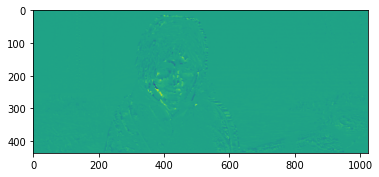

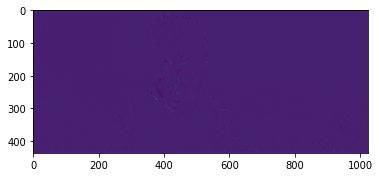

In [127]:
plt.imshow(v)
plt.show()
plt.imshow(u)
plt.show()